<a href="https://colab.research.google.com/github/jishnucv/MechineLearning/blob/main/Jishnu_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chemical Applications of Machine Learning (CHEM 4930/5610) - Spring 2026

### Assignment 2 - Deadline 2/3/2026
Points 10

#### General Comments
All figures and graph should have approriate labels on the two axis, and should include a legend with appropriate labels of the different plots.

The notebook should be return in working format. That is, I should be able to reset all the output and re-run all the cells and get the same results as you obtained.

**You should start by saving a copy of the notebook to your Google Drive so you preserve all changes.**

**Please add your name as a suffix to the filname**

**Student Name**: Jishnu Chevayil Vasudevan

**AI usage statement:**
I have used the help of Chatgpt to fine tune and correct the syntax of the codes especially in Task 1 , (D)

### Task 1 - 10 points

In this task, we will consider the Bradley Melting Point Dataset, which is curated chemical dataset with melting points of around 3,000 chemical compounds, see [here](https://www.kaggle.com/datasets/aliffaagnur/melting-point-chemical-dataset/data).

This dataset is stored in a comma-separated values (csv) file, which is common format used to start data in text files. We can load this into a pandas DataFrame using the `load_csv` function.

In this dataset, we have the compounds names, SMILES strings, and the melting point in Celsius.

#### A)
Identify in the dataset the chemical compounds with the 5 lowest melting points and 5 highest melting points and visualize their 2D chemical structure using RDKit and the [mols2grid package](https://mols2grid.readthedocs.io/en/latest/), where you display the melting point values on the grid, see [here](https://colab.research.google.com/github/PatWalters/practical_cheminformatics_tutorials/blob/main/fundamentals/A_Whirlwind_Introduction_To_The_RDKit.ipynb#scrollTo=N3CR7rMF3sg7) for an example of the usage of mols2grid.

#### B)
Calculate the following properties for the molecules using RDKIt:
- The molecular weight
- The number of heavy atoms
- Number of hydrogen bond acceptors
- Number of hydrogen bond donors
- [Octanol-water partition coefficient - LogP](https://pubs-acs-org.libproxy.library.unt.edu/doi/10.1021/ci990307l)
- [Topological polar surface area (TPSA) descriptor](https://pubs-acs-org.libproxy.library.unt.edu/doi/abs/10.1021/jm000942e)
- Topological polar surface area (TPSA) descriptor, including S and P atoms, see [here](https://www.rdkit.org/docs/RDKit_Book.html#implementation-of-the-tpsa-descriptor)

Note: for some of the molecules, the TPSA descriptor will give a value of zero. When doing any analysis for the TPSA descriptor, you should ignore these values.

#### C)
Write out to a new csv file values of all the properties calculated in B) along with the compound names, SMILES strings, and the melting point in Celsius. Here, when writing this file, you should ignore any compounds where the SMILES conversion did not work correctly.

#### D)
Perform a linear regression analysis using scikit-learn where you look at the correlation of each of the properties calculated in B) with melting temperature. Here, each property should be considered individually.

To avoid outliers, filter out (i.e., remove) the compounds with the lowest 10% and the highest 10% melting temperature. Make a histogram that shows this filtering. Furthermore, for each property, filter out the compounds with lowest 10% and highest 10% values (again making a histogram that shows this filtering). Only consider the joint remaining compounds in your linear regression analysis for each property.

When performing the linear regression, employ a 70%/30% training/test split.

Calculate the coefficient of determination, $R^2$, for both the training dataset and the test dataset and report both.

You should make figure that shows the data along with the linear curve coming from the linear regression. In the figure, it should be clear which data points are in the training and test set (e.g., by having them in different colors). Include the $R^2$ values on the figure.

From your analysis, which of the properties correlates best with the melting temperature?

#### E)
For two of the properties from D) (e.g., the ones that correlate best with the melting point), perform [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus) regression, which is method that takes outliers into account when performing linear regression and does not include them in the final modeling, see [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html).

In the figure, it should be clear which data points are in inlier set and which are in the outlier set (e.g., by showing them in different colors).


In [52]:
# Bash script to download all the dataset. Don't worry if you don't understand it
%%bash

url="https://raw.githubusercontent.com/valsson-group/UNT-ChemicalApplicationsOfMachineLearning-Spring2026/refs/heads/main/Assignment-2/"
dataset_filename="BradleyDoublePlusGoodMeltingPointDataset.csv"

rm -f ${dataset_filename}

wget ${url}/${dataset_filename} &> /dev/null

ls

BradleyDoublePlusGoodMeltingPointDataset.csv
calculated_properties.csv
Dataset_RotatedWQ-Potential.data
sample_data


In [53]:
%%capture
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install rdkit pandas seaborn mols2grid requests

In [54]:
from rdkit import Chem #RDKit Chemistry
from rdkit.Chem.Draw import IPythonConsole #RDKit drawing
from rdkit.Chem import Draw #RDKit drawing
from rdkit.Chem import rdDepictor
from rdkit.Chem import PandasTools #Add the ability to add a molecule to a dataframe
import mols2grid #The mols2grid library provides a convenient way of displaying molecules in a grid
import requests
import pandas as pd
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)

In [55]:
df = pd.read_csv('BradleyDoublePlusGoodMeltingPointDataset.csv')

In [56]:
print(df)

        key                        name  \
0     27956           cyclobutylmethane   
1     16005              Nitrogen oxide   
2     16127         Sulfuryl difluoride   
3     17138                disopyramide   
4     15628                     Bromine   
...     ...                         ...   
3036  27698         4-Nitrobenzoic acid   
3037  28584                 Thalidomide   
3038  28068                   Estradiol   
3039  27580       2,4,6-Trichlorophenol   
3040   1059  2-(trifluoromethyl)aniline   

                                                 smiles     mpC      csid  \
0                                             C1(CCC1)C -161.51     11232   
1                                            [O-][N+]#N  -90.80       923   
2                                           FS(F)(=O)=O -135.80     16647   
3            CC(C)N(CCC(c1ccccn1)(c2ccccc2)C(N)=O)C(C)C   94.80      3002   
4                                                  BrBr   -7.20     22817   
...                  

In [57]:
lowest = df.nsmallest(5, 'mpC') # for the lowest mp
highest = df.nlargest(5, 'mpC') # for the highest mp
extremes = pd.concat([lowest, highest])

In [58]:
print(lowest)
print(highest)

       key                name     smiles     mpC  csid  \
375  16083             Propane        CCC -188.00  6094   
102  16080          Prop-1-ene       C=CC -185.00  7954   
303  15635           But-1-ene      C=CCC -185.00  7556   
345  16142  Tetrafluoromethane  FC(F)(F)F -184.00  6153   
821  28073              ethane         CC -183.33  6084   

                                                link  \
375                       http://msds.chem.ox.ac.uk/   
102                       http://msds.chem.ox.ac.uk/   
303                       http://msds.chem.ox.ac.uk/   
345                       http://msds.chem.ox.ac.uk/   
821  http://pubs.acs.org/doi/pdf/10.1021/je60044a013   

                                                source  count     min     max  \
375                                   academic website      3 -188.00 -187.60   
102                                   academic website      4 -185.20 -185.00   
303                                   academic website      3 -18

In [59]:
mols2grid.display(extremes, smiles_col="smiles", subset=["name", "mpC"], n_cols=5)

Task 1 B

In [60]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import MolSurf

In [61]:
from rdkit.Chem import Descriptors, Lipinski, MolFromSmiles

def calculate_properties(smiles):
    mol = MolFromSmiles(smiles)
    if mol is None:
        return [None] * 7

    # Standard Descriptors
    mw = Descriptors.MolWt(mol)
    heavy_atoms = mol.GetNumHeavyAtoms()
    hba = Lipinski.NumHAcceptors(mol)
    hbd = Lipinski.NumHDonors(mol)
    logp = Descriptors.MolLogP(mol)

    # TPSA (standard - usually O and N)
    tpsa = Descriptors.TPSA(mol)

    # TPSA (including S and P)
    # RDKit's TPSA by default can include S and P if the flag is set
    # but the standard Descriptors.TPSA is based on the Peter Ertl algorithm (O, N)
    # For S and P, we use the specific LabuteASA or custom TPSA if required by your specific library version
    tpsa_sp = Descriptors.TPSA(mol, includeSandP=True)

    return [mw, heavy_atoms, hba, hbd, logp, tpsa, tpsa_sp]

# Apply to the dataframe
columns = ['MW', 'HeavyAtoms', 'HBA', 'HBD', 'LogP', 'TPSA', 'TPSA_SP']
df[columns] = df['smiles'].apply(lambda x: pd.Series(calculate_properties(x)))

# Ignore TPSA values that are zero for analysis
df_filtered_tpsa = df[df['TPSA'] > 0]

[22:11:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[22:11:09] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[22:11:09] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28 31 32 33 34
[22:11:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[22:11:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[22:11:09] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[22:11:09] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[22:11:09] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[22:11:09] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8
[22:11:09] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[22:11:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[22:11:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[22:11:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 12 13 14 15 16
[22:11:10] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[22:11:10] Can't kekulize mol.  Unkekuliz

In [62]:
from rdkit.Chem import Descriptors, Lipinski, MolFragmentToSmiles

In [63]:
def calculate_properties(smiles):
    # Try to create the molecule
    mol = MolFromSmiles(smiles)

    # If RDKit returns None (because of kekulization or other errors)
    if mol is None:
        return [None] * 7

    try:
        # Sometimes MolFromSmiles works, but Descriptors fail
        # We wrap the calculations in a try-except block just in case
        mw = Descriptors.MolWt(mol)
        heavy_atoms = mol.GetNumHeavyAtoms()
        hba = Lipinski.NumHAcceptors(mol)
        hbd = Lipinski.NumHDonors(mol)
        logp = Descriptors.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        tpsa_sp = Descriptors.TPSA(mol, includeSandP=True)

        return [mw, heavy_atoms, hba, hbd, logp, tpsa, tpsa_sp]
    except:
        return [None] * 7

In [64]:
# 1. Sort the dataframe by Melting Point
# Replace 'Melting Point' with 'mp' if that is your column name
df_sorted = df.sort_values(by='mpC')

# 2. Slice the 5 lowest and 5 highest
lowest_5 = df_sorted.head(5)
highest_5 = df_sorted.tail(5)

# 3. Combine them into one display dataframe
extremes_df = pd.concat([lowest_5, highest_5])

# 4. Print the output
print("\n--- Descriptors for 5 Lowest and 5 Highest MP Compounds ---")
print(extremes_df[['name', 'mpC', 'MW', 'LogP', 'TPSA', 'TPSA_SP']].round(2).to_string(index=False))


--- Descriptors for 5 Lowest and 5 Highest MP Compounds ---
                           name     mpC     MW  LogP  TPSA  TPSA_SP
                        Propane -188.00  44.10  1.42  0.00     0.00
                     Prop-1-ene -185.00  42.08  1.19  0.00     0.00
                      But-1-ene -185.00  56.11  1.58  0.00     0.00
             Tetrafluoromethane -184.00  88.00  1.48  0.00     0.00
                         ethane -183.33  30.07  1.03  0.00     0.00
                      Diazoxide  330.50 230.68  1.87 58.53    66.91
               isophthalic_acid  342.00 166.13  1.08 74.60    74.60
         2,4-dihydroxypteridine  348.00 164.12 -0.99 91.50    91.50
thiophene-2,5-dicarboxylic acid  358.00 172.16  1.14 74.60   102.84
                       Coronene  438.00 300.36  6.92  0.00     0.00


1C Task

In [65]:
df.to_csv("calculated_properties.csv", index=False)

1D Task

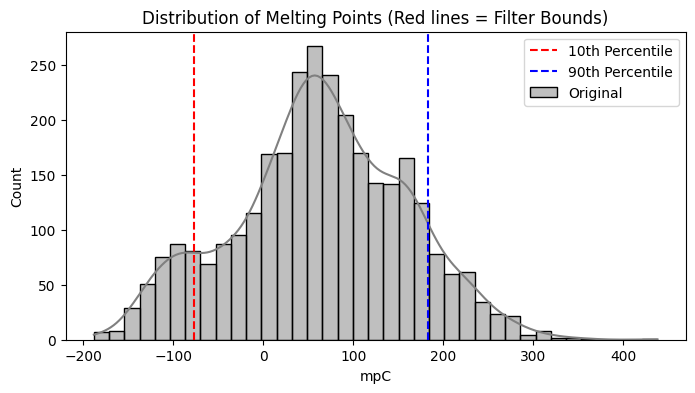

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load your data from the CSV created previously
df = pd.read_csv("calculated_properties.csv")

def filter_outliers(data, column):
    lower = data[column].quantile(0.10)
    upper = data[column].quantile(0.90)
    filtered = data[(data[column] > lower) & (data[column] < upper)]
    return filtered, lower, upper

# Initial filter: Melting Point
df_mp_filtered, mp_low, mp_high = filter_outliers(df, "mpC")

# Histogram for MP Filtering
plt.figure(figsize=(8, 4))
sns.histplot(df["mpC"], kde=True, color='grey', label='Original')
plt.axvline(mp_low, color='red', linestyle='--', label='10th Percentile')
plt.axvline(mp_high, color='blue', linestyle='--', label='90th Percentile')
plt.title("Distribution of Melting Points (Red lines = Filter Bounds)")
plt.legend()
plt.show()

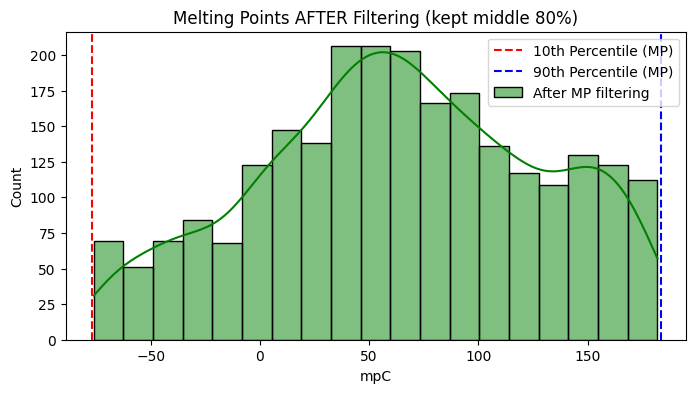

Skipping MolWt: not found in CSV columns.
Skipping HeavyAtomCount: not found in CSV columns.


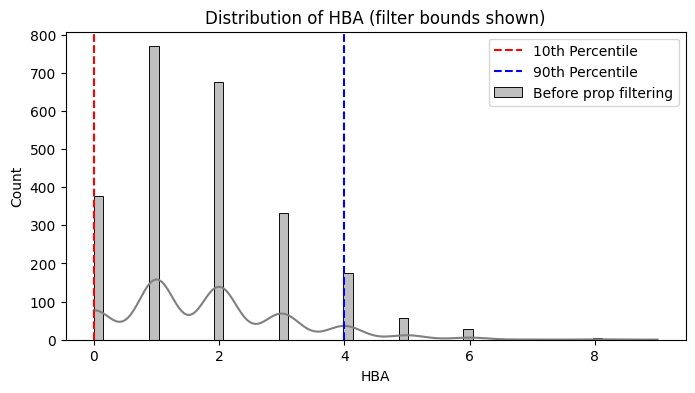

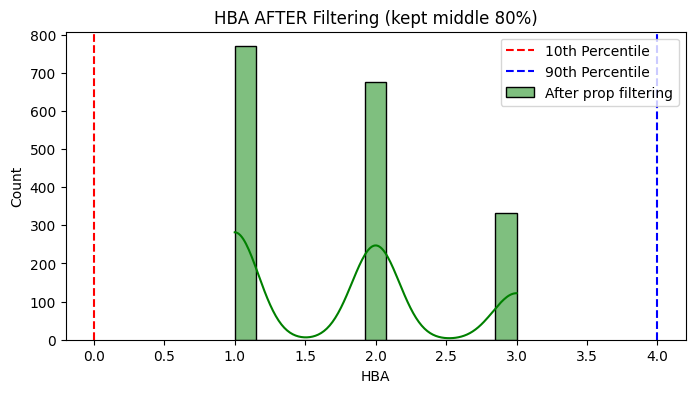

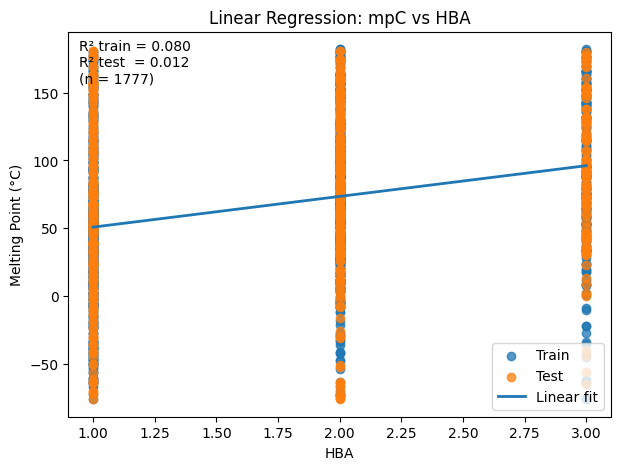

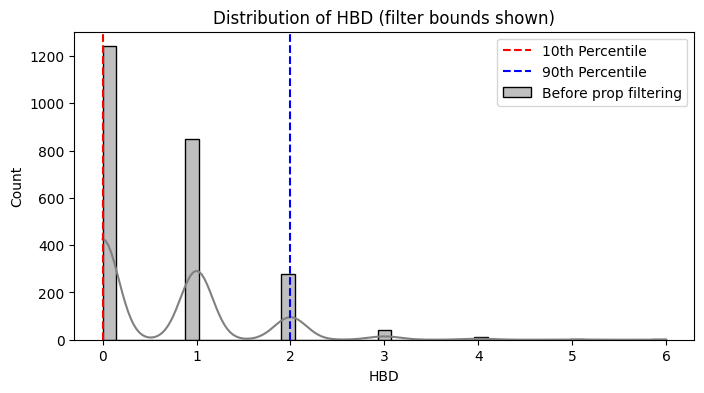

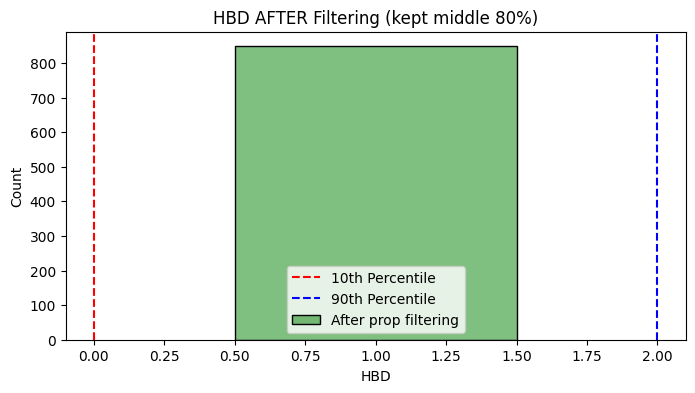

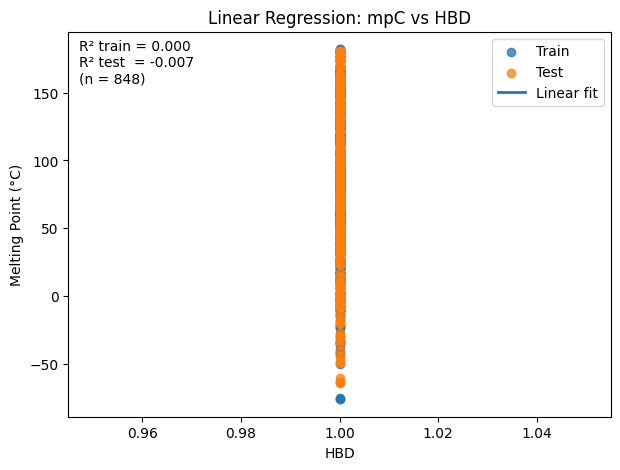

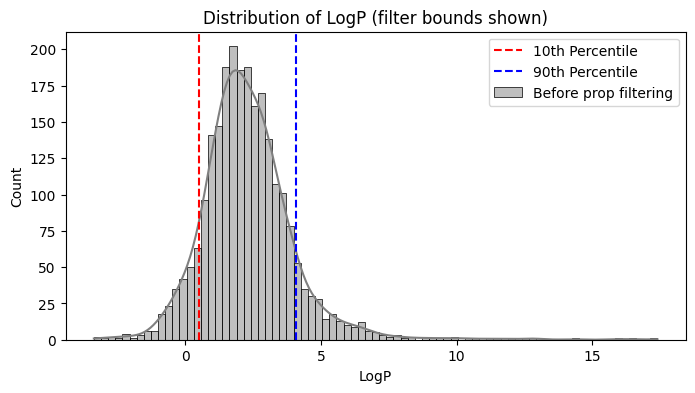

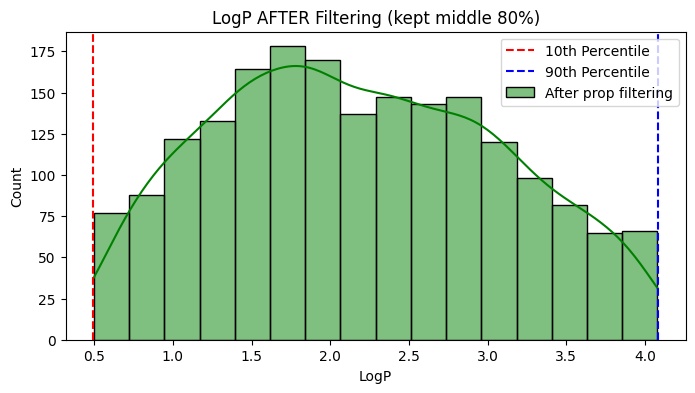

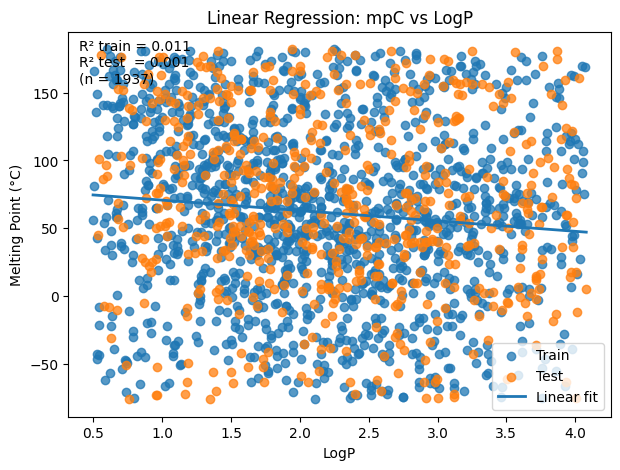

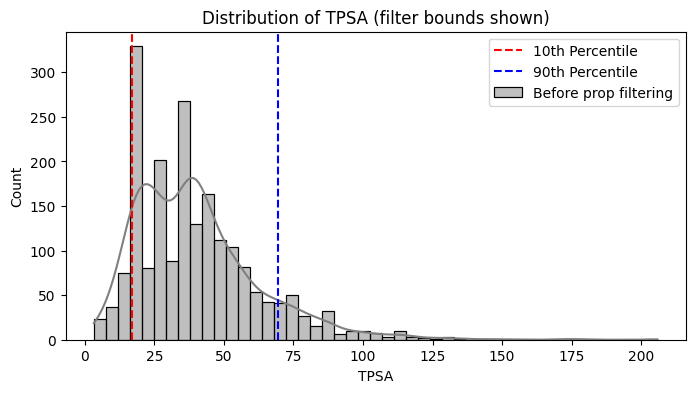

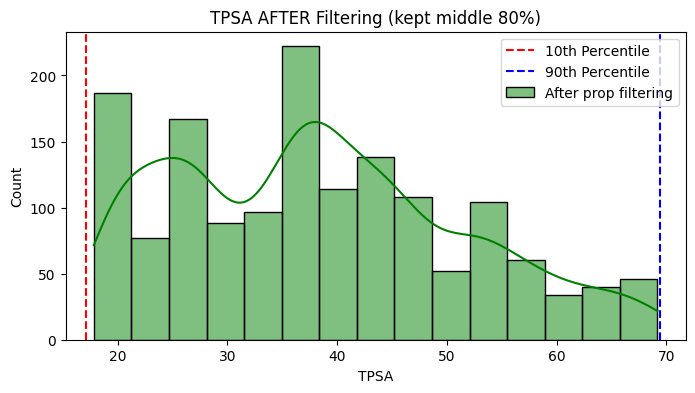

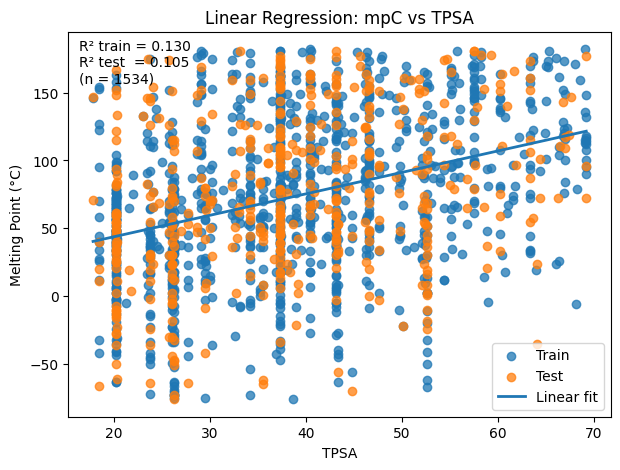

Skipping TPSA_S_P: not found in CSV columns.

=== Summary (sorted by best TEST R²) ===


,property,n_joint,slope,intercept,r2_train,r2_test
3,TPSA,1534,1.581627,12.144473,0.130071,0.105307
0,HBA,1777,22.649149,28.209994,0.080050,0.011645
2,LogP,1937,-7.658118,78.406540,0.011032,0.000582
1,HBD,848,0.000000,83.120152,0.000000,-0.006540



Best correlating property (highest TEST R²): TPSA
R² test  = 0.105
R² train = 0.130
n (joint) = 1534


In [75]:
# Show histogram AFTER MP filtering (kept data)
plt.figure(figsize=(8, 4))
sns.histplot(df_mp_filtered["mpC"], kde=True, color='green', label='After MP filtering')
plt.axvline(mp_low, color='red', linestyle='--', label='10th Percentile (MP)')
plt.axvline(mp_high, color='blue', linestyle='--', label='90th Percentile (MP)')
plt.title("Melting Points AFTER Filtering (kept middle 80%)")
plt.legend()
plt.show()

# Properties from part B (edit these names if your CSV uses different headers)
properties = [
    "MolWt",
    "HeavyAtomCount",
    "HBA",
    "HBD",
    "LogP",
    "TPSA",
    "TPSA_S_P"   # TPSA including S and P atoms (your computed column)
]

# If TPSA columns sometimes have zeros and you want to ignore zeros (as you said earlier)
tpsa_zero_ignore = {"TPSA", "TPSA_S_P"}

results = []

for prop in properties:
    if prop not in df.columns:
        print(f"Skipping {prop}: not found in CSV columns.")
        continue

    # Start from MP-filtered data (first filter)
    d = df_mp_filtered.copy()

    # Remove NaN for this property
    d = d.dropna(subset=[prop, "mpC"])

    # Ignore zeros for TPSA-like descriptors (optional but matches your earlier instruction)
    if prop in tpsa_zero_ignore:
        d = d[d[prop] != 0]

    if len(d) < 30:
        print(f"Skipping {prop}: too few rows after NaN/zero removal (n={len(d)}).")
        continue

    # Property outlier filtering (10% / 90%)
    d_prop_filtered, p_low, p_high = filter_outliers(d, prop)

    # Histogram for property filtering (before)
    plt.figure(figsize=(8, 4))
    sns.histplot(d[prop], kde=True, color='grey', label='Before prop filtering')
    plt.axvline(p_low, color='red', linestyle='--', label='10th Percentile')
    plt.axvline(p_high, color='blue', linestyle='--', label='90th Percentile')
    plt.title(f"Distribution of {prop} (filter bounds shown)")
    plt.legend()
    plt.show()

    # Histogram for property filtering (after)
    plt.figure(figsize=(8, 4))
    sns.histplot(d_prop_filtered[prop], kde=True, color='green', label='After prop filtering')
    plt.axvline(p_low, color='red', linestyle='--', label='10th Percentile')
    plt.axvline(p_high, color='blue', linestyle='--', label='90th Percentile')
    plt.title(f"{prop} AFTER Filtering (kept middle 80%)")
    plt.legend()
    plt.show()

    # Joint remaining compounds already ensured because:
    # - d is MP-filtered
    # - d_prop_filtered is also property-filtered
    joint = d_prop_filtered[[prop, "mpC"]].dropna()

    if len(joint) < 30:
        print(f"Skipping {prop}: too few rows after joint filtering (n={len(joint)}).")
        continue

    # X/y
    X = joint[[prop]].values
    y = joint["mpC"].values

    # 70/30 train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=0
    )

    # Linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions + R2
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Save results
    results.append({
        "property": prop,
        "n_joint": len(joint),
        "slope": float(model.coef_[0]),
        "intercept": float(model.intercept_),
        "r2_train": float(r2_train),
        "r2_test": float(r2_test),
    })

    # Plot scatter (train/test) + regression line
    plt.figure(figsize=(7, 5))
    plt.scatter(X_train.ravel(), y_train, alpha=0.75, label="Train")
    plt.scatter(X_test.ravel(), y_test, alpha=0.75, label="Test")

    x_line = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
    y_line = model.predict(x_line)
    plt.plot(x_line.ravel(), y_line, linewidth=2, label="Linear fit")

    plt.title(f"Linear Regression: mpC vs {prop}")
    plt.xlabel(prop)
    plt.ylabel("Melting Point (°C)")
    plt.legend()

    plt.text(
        0.02, 0.98,
        f"R² train = {r2_train:.3f}\nR² test  = {r2_test:.3f}\n(n = {len(joint)})",
        transform=plt.gca().transAxes,
        va="top"
    )

    plt.show()


# Summary table + best correlate
results_df = pd.DataFrame(results).sort_values("r2_test", ascending=False)
print("\n=== Summary (sorted by best TEST R²) ===")
display(results_df)

if len(results_df) > 0:
    best = results_df.iloc[0]
    print(f"\nBest correlating property (highest TEST R²): {best['property']}")
    print(f"R² test  = {best['r2_test']:.3f}")
    print(f"R² train = {best['r2_train']:.3f}")
    print(f"n (joint) = {int(best['n_joint'])}")
else:
    print("No valid regressions produced results after filtering.")


### Task 2 - Optional 5 points

Here we will consider a dataset of two variables $x$ and $y$ sampled from a two-dimensional probability density $P(x,y)$ that is unknown.

The dataset is given as a time series in the file `Dataset_RotatedWQ-Potential.data`.

The main task is to perform a Gaussian Mixture Model analysis on this two-dimensional dataset.

#### A)
Plot the dataset, both the time series and also a scatter plot for the $x$ and $y$ variables.

Looking at the scatter plot, how many Gaussian components do you think are needed in the Gaussian Mixture Model analysis?

#### B)
Using Seaborn (or scikit-learn) estimate the two-dimensional probability density $P(x,y)$ using kernel density estimation.

#### C)
Perform a Gaussian Mixture Model analysis for a different number of components, and obtain the Bayesian information criterion (bic) and Akaike information criterion (aic) values and based on them identify the optimal number of components (remember that for both a lower value is better).

#### D)
For the optimal number of components, perform a final Gaussian Mixture Model analysis that you will analyze.

- What is the weight of each Gaussian components.

- What is the percentage of samples that are hard classifed to each cluster.

- Make a scatter plot that shows how the samples are hard classifed to each cluster. In this plot, indicate the center of each Gaussian components.

- Make figures that shows how the samples are soft classifed to each cluster (e.g., the probablity that they belong to a given cluster). In each plot, indicate the center of corresponding Gaussian components.

- Plot a two-dimensional surface of the $P(x,y)$ estimated by the Gaussian Mixture Model. How does this compare to the KDE plot from B)?


In [ ]:
# Bash script to download all the dataset. Don't worry if you don't understand it
%%bash

url="https://raw.githubusercontent.com/valsson-group/UNT-ChemicalApplicationsOfMachineLearning-Spring2026/refs/heads/main/Assignment-2/"
dataset_filename="Dataset_RotatedWQ-Potential.data"

rm -f ${dataset_filename}

wget ${url}/${dataset_filename} &> /dev/null

ls



In [ ]:
ls

Time series plot is given by

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.loadtxt("Dataset_RotatedWQ-Potential.data")
t = data[:, 0]
x = data[:, 1]
y = data[:, 2]
#print(data)
# Time series plot
plt.figure(figsize=(10, 4))
plt.plot(t,x, label='x(t)', alpha=0.8)
plt.plot(t,y, label='y(t)', alpha=0.8)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time series of x and y")
plt.legend()
plt.tight_layout()
plt.show()


Scatter Plot is given by

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(x, y, s=5, alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter plot of x vs y")
plt.axis("equal")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.loadtxt("Dataset_RotatedWQ-Potential.data")
x = data[:, 1]
y = data[:, 2]

# Create time axis (index-based)
#time = np.arange(len(x))

stride = 1

# x time series (scatter)
plt.figure()
plt.plot(time[::stride], x[::stride], '.', label="x")
plt.xlabel("Time [ps]")
plt.ylabel("x")
plt.legend()
plt.show()

# y time series (scatter)
plt.figure()
plt.plot(time[::stride], y[::stride], '.', label="y")
plt.xlabel("Time [ps]")
plt.ylabel("y")
plt.legend()
plt.show()


Looking at the scatter plot it is clear that they contain two sets of distribution , hence we may need two guassian components needed for the analysis of this data, Probably bimodel.

Task 2 , B

True
3
Gaussian Mixture Model (2D)
0 - Weight: 0.793 / Mean: (-1.710, 0.759)
1 - Weight: 0.207 / Mean: (1.381, -0.865)


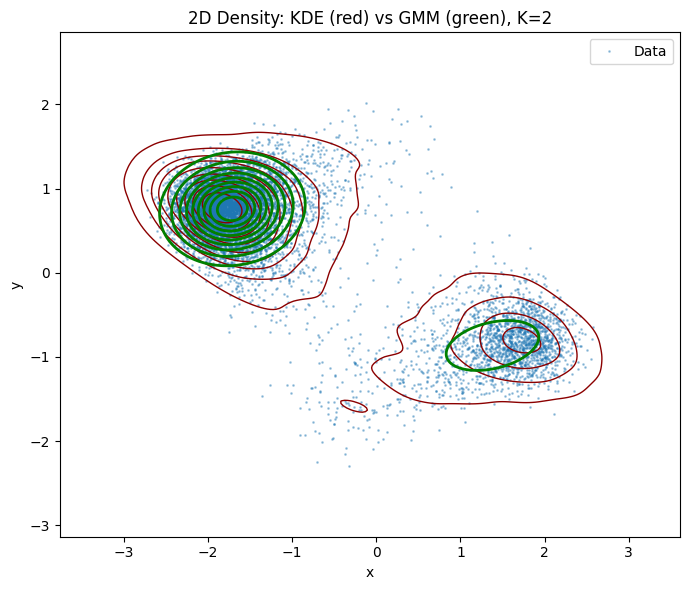

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

# Load data (assumes 2 columns: x y)
data = np.loadtxt("Dataset_RotatedWQ-Potential.data")
x = data[:, 1]
y = data[:, 2]
XY = np.column_stack([x, y])

gmm_n_components = 2  # based on the scatter plot (usually 2 wells)

gm = GaussianMixture(
    n_components=gmm_n_components,
    random_state=0,
    n_init=10,
    covariance_type="full"
)

gm.fit(XY)

print(gm.converged_)
print(gm.n_iter_)

print("Gaussian Mixture Model (2D)")
for i in range(gmm_n_components):
    print(f"{i} - Weight: {gm.weights_[i]:.3f} / Mean: ({gm.means_[i][0]:.3f}, {gm.means_[i][1]:.3f})")

# --- Build grid for density evaluation ---
nx = ny = 250
x_grid = np.linspace(x.min(), x.max(), nx)
y_grid = np.linspace(y.min(), y.max(), ny)
Xg, Yg = np.meshgrid(x_grid, y_grid)
grid_points = np.column_stack([Xg.ravel(), Yg.ravel()])

# GMM density on grid
logP_gmm = gm.score_samples(grid_points)
P_gmm = np.exp(logP_gmm).reshape(ny, nx)

# --- Plot: scatter + KDE contours + GMM contours ---
plt.figure(figsize=(7, 6))

# Scatter (like your dot-style)
plt.plot(x, y, '.', ms=2, alpha=0.35, label="Data")

# KDE estimate of P(x,y)
sns.kdeplot(x=x, y=y, levels=10, linewidths=1, color="darkred", label="KDE contours")

# GMM density contours
plt.contour(Xg, Yg, P_gmm, levels=10, linewidths=2, colors="green")

plt.xlabel("x")
plt.ylabel("y")
plt.title(f"2D Density: KDE (red) vs GMM (green), K={gmm_n_components}")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()


In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

 Load data (assumes 2 columns: x y)
data = np.loadtxt("Dataset_RotatedWQ-Potential.data")
x = data[:, 1]
y = data[:, 2]
XY = np.column_stack([x, y])
print('x')

# Choose variables
x = "MolWt"
y = "mpC"

# Basic clean
d = df[[x_col, y_col]].replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(7,5))
sns.kdeplot(
    data=d, x=x_col, y=y_col,
    fill=True, levels=30, thresh=0.0
)
plt.title(f"2D KDE estimate of P({x_col}, {y_col})")
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.show()


IndentationError: unexpected indent (ipython-input-3768852569.py, line 6)

In [83]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.kdeplot(
    x=x,
    y=y,
    fill=True,
    levels=40,
    thresh=0.0,
    cmap="viridis"
)

plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Kernel Density Estimate P(x, y)")
plt.show()


ValueError: Could not interpret value `MolWt` for `x`. Value is a string, but `data` was not passed.

<Figure size 600x500 with 0 Axes>